In [ ]:
import pandas as pd
import numpy as np
import geopandas
import statsmodels as sm
import statsmodels.api as sma
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import os
import plotly.express as px
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Alexes_Bansal_Lab/Prison Vaccinaiton Project/')
wd='/content/drive/MyDrive/Alexes_Bansal_Lab/Prison Vaccinaiton Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### CREATE DATA FILE with vaccinated/unvaccinated numbers in each state, and various covariates/predictors (prioritiezed, decarcerated, non-inc-coverage, ...)

In [ ]:
states_abbrevs = {'AK':'Alaska','AL':'Alabama','AR':'Arkansas','AZ':'Arizona', 'CA':'California','CO':'Colorado',
    'CT':'Connecticut','DC':'District of Columbia','DE':'Delaware','FL':'Florida','GA':'Georgia',
    'HI':'Hawaii','IA':'Iowa','ID':'Idaho','IL':'Illinois','IN':'Indiana','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'MA':'Massachusetts','MD':'Maryland','ME':'Maine','MI':'Michigan','MN':'Minnesota','MO':'Missouri','MS':'Mississippi',
    'MT':'Montana','NC':'North Carolina','ND':'North Dakota','NE':'Nebraska','NH':'New Hampshire','NJ':'New Jersey',
    'NM':'New Mexico','NV':'Nevada','NY':'New York','OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
    'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah',
    'VA':'Virginia','VT':'Vermont','WA':'Washington','WI':'Wisconsin','WV':'West Virginia','WY':'Wyoming'}

In [ ]:
###########

df = pd.read_csv(wd+'/Data/Cleaned/UCLA_statewide_temporal.csv')

print(len(df['State'].unique()))
# We're going to define our response variable (y variable) as coverage at Oct 2021
# so drop all the coverage data besides that from first week fo October
df.Date = pd.to_datetime(df.Date)
df = df[(df.Date > '12-01-2021') & (df.Date < '12-10-2021')]

# create not vaccinated column (this is needed for the glm model)
df['Residents.NotInitiated'] = df['Population_Dec2021'] - df['Residents.Initiated']

# create prioritized column
df['Prioritized'] = df['Prioritization?'].map({'yes':1, "no":0})

# get decarcerated status
df_pops=pd.read_csv('Data/Cleaned/state_pops.csv')
df_decar=df_pops.loc[(df_pops['pop_change']<=-0.2)] ##decarceration is any state that ever saw a 20% or more decrease in popualtion
decarcerated_states=list(df_decar['name'].unique()) ##column with state name
states=list(df['State'].unique())
non_decarcerated=[x for x in states if x not in decarcerated_states ]
df['Decarcerated'] = np.where(df['State'].isin(decarcerated_states), 1, np.where(df['State'].isin(non_decarcerated), 0, float('NaN')))

# get non-inc coverage
df_noninc=pd.read_csv(wd+'Data/Cleaned/data_county_timeseries.csv')
df_noninc=df_noninc.loc[df_noninc['CASE_TYPE']=='Partial']
df_noninc=df_noninc.loc[df_noninc['WEEK']==48] # December 1st week
df_noninc=df_noninc.loc[df_noninc['YEAR']==2021]
df_noninc = df_noninc.groupby('STATE_NAME')[['CASES', 'POPN']].sum().reset_index()
df_noninc['State']=df_noninc['STATE_NAME'].replace(states_abbrevs)
df_noninc['Non-Incarcerated Coverage'] = df_noninc['CASES']/df_noninc['POPN']
df_noninc = df_noninc[['State', 'Non-Incarcerated Coverage','STATE_NAME']]
#print(df_noninc.head())
df = df.merge(df_noninc, on='State',how='outer')

# make dataset smaller-- just keep what we need
df = df[['State', 'Residents.Initiated', 'Residents.NotInitiated', 'Non-Incarcerated Coverage', 'Prioritized', 'Decarcerated','Date_prioritized','STATE_NAME']]





# drop any rows with NAs (drops Minnesota)
df = df.loc[df['State']!='Minnesota']



27


In [ ]:

##Get decarceration percentage

decar_amount=pd.DataFrame(columns=['State','Decarceration'])
file_decar=open(wd+'/Data/Cleaned/state_pops.csv')
df_pops=pd.read_csv(file_decar)
df_pops['Date']=pd.to_datetime(df_pops['Date'])
df_pops = df_pops[df_pops['Date'].dt.strftime('%Y-%m') == '2020-12']

for state in df_pops['name'].unique():
    df_pop_state=df_pops.loc[df_pops['name']==state].reset_index()
    decar=df_pop_state['pop_change'][0]
    df2 = pd.DataFrame({'State':[state],'Decarceration':[decar]})

    decar_amount = pd.concat([decar_amount, df2], ignore_index=True)

decar_amount


df=pd.concat([decar_amount.set_index('State'),df.set_index('State')], axis=1, join='inner')
df=df.reset_index()
df['Decarceration']=df['Decarceration']*(-1)


<ipython-input-12-d93c7b2f3d54>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  decar_amount = pd.concat([decar_amount, df2], ignore_index=True)


In [ ]:

file_incentive=open(wd+'/Data/Cleaned/prison_state_incentive.csv')

df_incentive=pd.read_csv(file_incentive)

df_incentive=df_incentive.set_index('State')


df=pd.concat([df_incentive,df.set_index('State')], axis=1, join='outer')


In [ ]:
file_general=open(wd+'Data/Cleaned/General_public_stats.csv')

df_general=pd.read_csv(file_general)

df_general=df_general.set_index('State')

df=pd.concat([df_general,df], axis=1, join='inner')

df['General_public']=pd.to_datetime(df['General_public'],format='%m/%d/%Y')

df['Date_prioritized']=pd.to_datetime(df['Date_prioritized'],format='%Y-%m-%d')

df['Days Prioritized']=''



for i, row in df.iterrows():
    if df.at[i,'Date_prioritized']!=np.nan:
        df.at[i,'Days Prioritized'] = (df.at[i,'General_public'] - df.at[i,'Date_prioritized']).days
    if df.at[i,'Date_prioritized'] ==np.nan:
        df.at[i,'Days Prioritized']=0
df['Days Prioritized']=df['Days Prioritized'].fillna(0)
df=df.rename(columns={"Non-Incarcerated Coverage": "Non-Incarcerated \n Coverage"})
df=df.rename(columns={"Days Prioritized": "Days \n Prioritized"})

<ipython-input-14-f4e1aa79f157>:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Days Prioritized']=df['Days Prioritized'].fillna(0)


In [ ]:
# response
df_proper = df[df['Residents.Initiated'].notna()]
df_proper = df_proper[df_proper['Residents.NotInitiated'].notna()]
df_proper = df_proper[df_proper["Non-Incarcerated \n Coverage"].notna()]
df_proper = df_proper[df_proper["Days \n Prioritized"].notna()]
df_proper = df_proper[df_proper['Decarceration'].notna()]
df_proper = df_proper[df_proper['Incentive'].notna()]

df_response = df_proper[['Residents.Initiated', 'Residents.NotInitiated']]

#covariates
df_covariates = df_proper[["Non-Incarcerated \n Coverage", "Days \n Prioritized", 'Decarceration','Incentive']]

# standardize covariates
for col_name in df_covariates.columns:
    df_covariates[col_name] = (df_covariates[col_name])/df_covariates[col_name].std()


glm_binom = sma.GLM(df_response, df_covariates, family=sma.families.Binomial())
res = glm_binom.fit()

<ipython-input-15-3cf43e4c6549>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covariates[col_name] = (df_covariates[col_name])/df_covariates[col_name].std()


In [ ]:
import geopandas
states = geopandas.read_file(wd+'Data/States_shapefile.shx')
#gdf = geopandas.GeoDataFrame(df)
states['State']=["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware","District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

states=states.loc[(states['State'] != 'Alaska')&(states['State'] != 'Hawaii')]
df_maps=pd.DataFrame(states)
df_maps=df_maps.merge(df,on='State',how='outer')
df_maps['Incentive']=df_maps['Incentive'].replace({1.0:'Incentives',0.0:'No Incentives'})


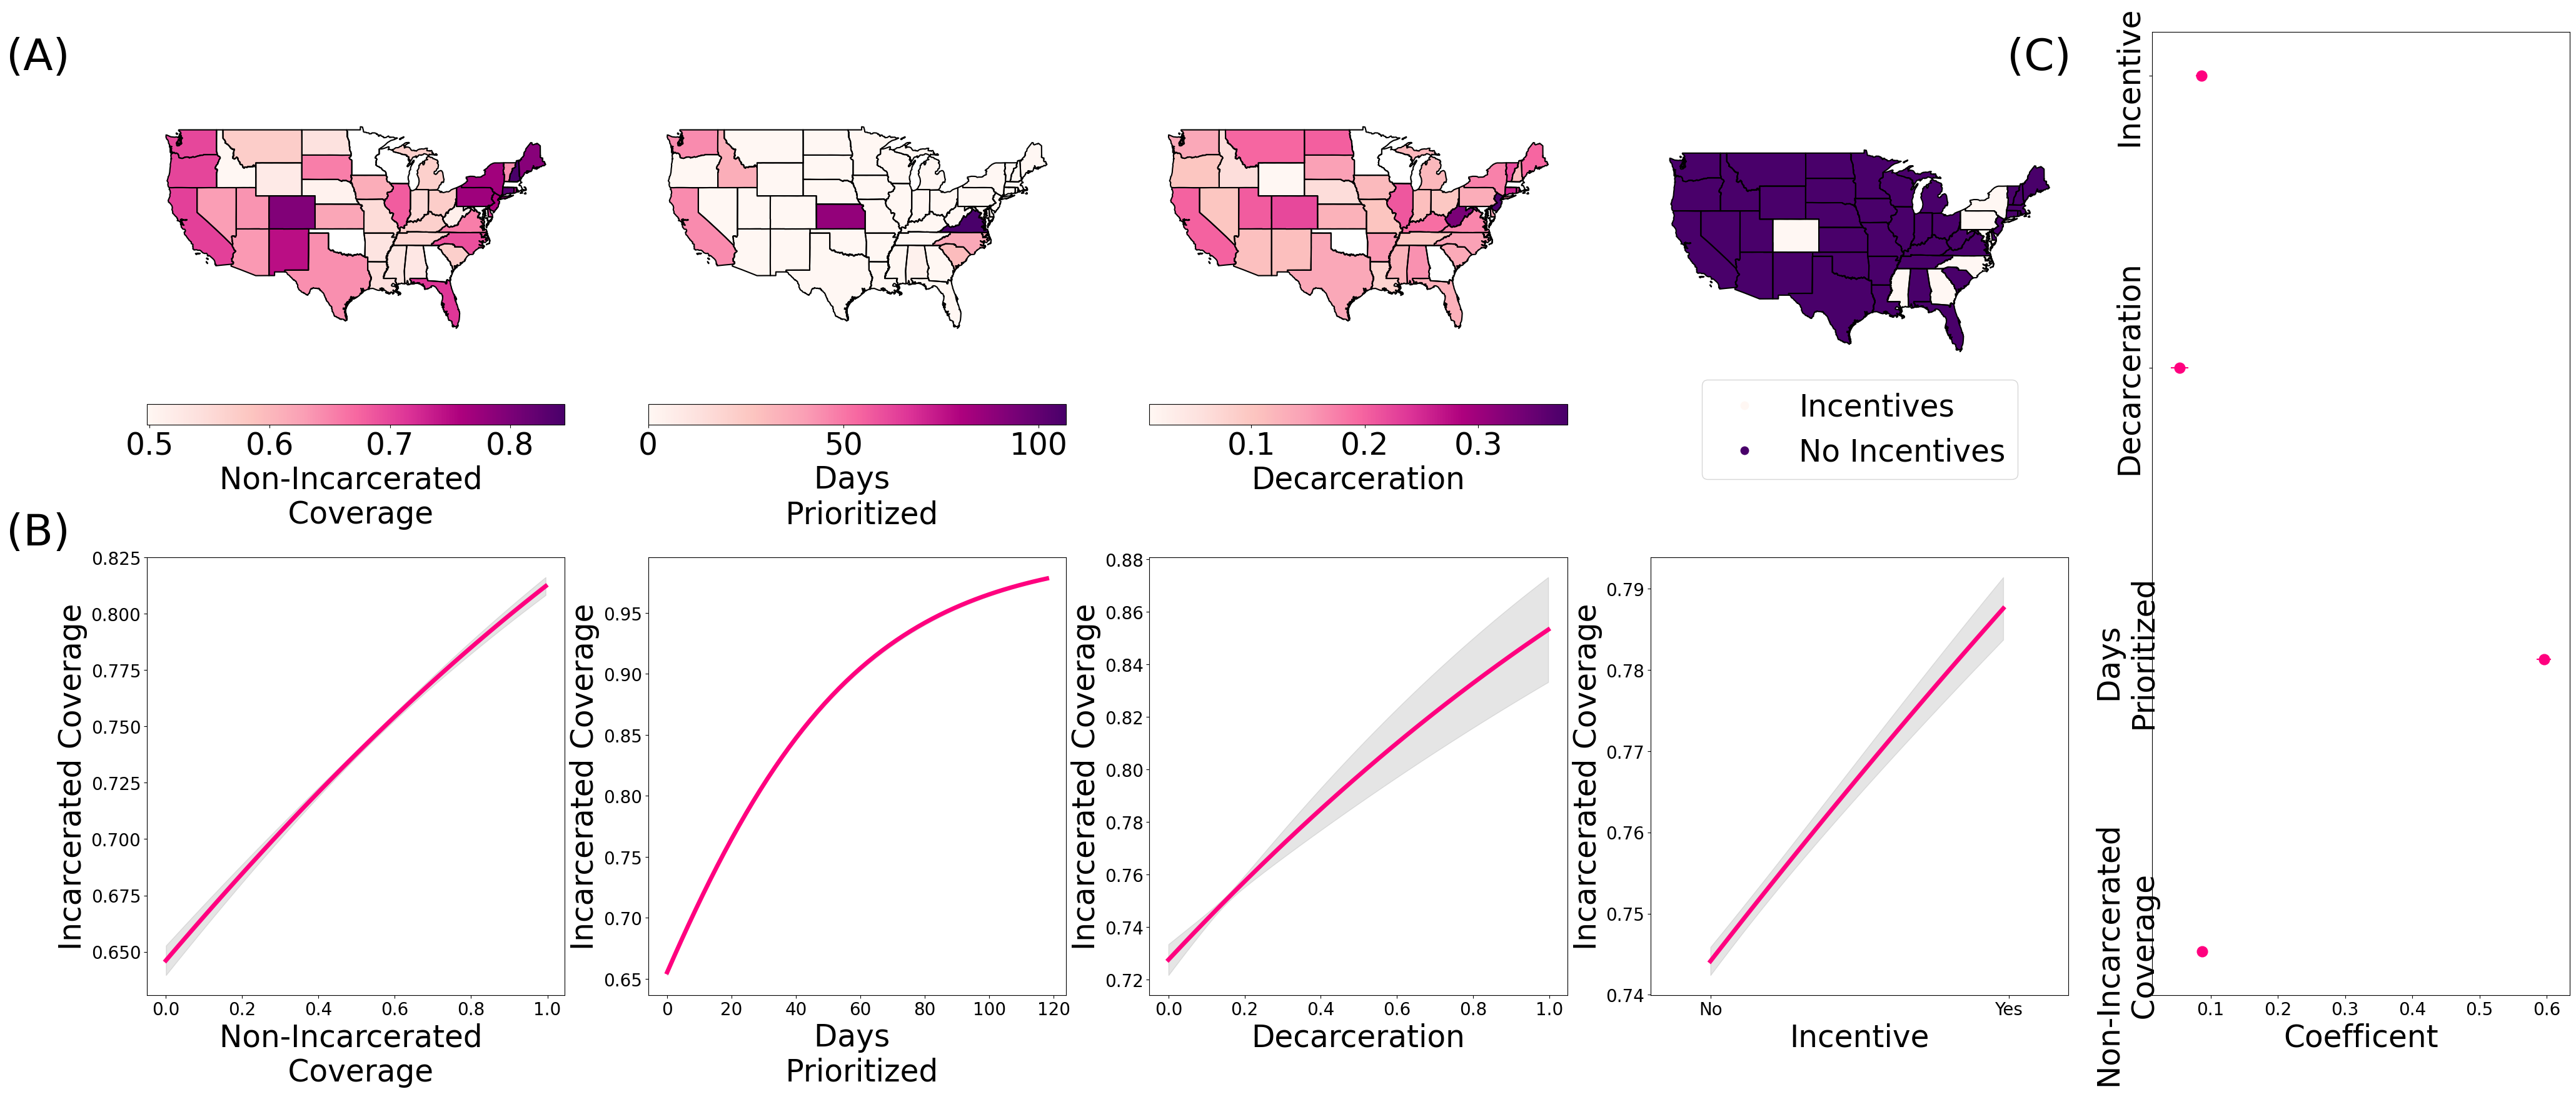

In [ ]:
rates=[]
states= geopandas.GeoDataFrame(df_maps, crs="EPSG:4326",geometry='geometry')
# MARGINAL EFFECT PLOT
grid = (2, 5)

fig = plt.figure(figsize=(50, 20))  # or whatever

#ax = plt.subplot2grid(grid, (0,4), rowspan=2,colspan=1)  # left column plot
graph1 = plt.subplot2grid(grid, (1, 0))  # right column upper plot
graph2 = plt.subplot2grid(grid, (1, 1))  # right column lower plot
graph3 = plt.subplot2grid(grid, (1, 2))  # right column upper plot
graph4 = plt.subplot2grid(grid, (1, 3))  # right column upper plot

map1 = plt.subplot2grid(grid, (0, 0))  # right column upper plot
map2 = plt.subplot2grid(grid, (0, 1))  # right column lower plot
map3 = plt.subplot2grid(grid, (0, 2))  # right column upper plot
map4 = plt.subplot2grid(grid, (0, 3))  # right column upper plot

axes=[graph1,graph2,graph3,graph4]
maps=[map1,map2,map3,map4]
######################################PLOTTING COVARIATE VS INCARCERATED COVERAGE##############################################################
# make a marginal effect plot for each covariate
for num in range(0,4):
    col_name=df_covariates.columns[num]
    ax=axes[num]
    # create a list of covariate names, excluding col_name
    other_col_names = list(df_covariates.columns)
    other_col_names.remove(col_name)

    ###################################
    # create hypothetical range of covariates
    # for col_name, we want to explore the range of values this variable can take
    # for other covariates, we want to fix them at their mean value
    X_range = pd.DataFrame(columns = df_covariates.columns)
    if col_name=='Days \n Prioritized':
        X_range[col_name] = np.arange(0,120/df[col_name].std(), 0.1)
    else:
        X_range[col_name] = np.arange(0,1/df[col_name].std(), 0.1)
    for other_col in other_col_names:
        X_range[other_col] = df_covariates[other_col].mean()

    ###################################
    # Get the predicted values and standard errors for the range of x values
    y_pred = res.predict(X_range)
    y_std = res.get_prediction(X_range).se_mean

    ###################################
    # Plot the data and regression line with confidence intervals

    # since we had standardized the x values by their std, we need to undo that so that the plot shows the right value
    x_plot = X_range[col_name]*df[col_name].std()
    rates.append([list(zip(x_plot,y_pred))])
    ax.plot(x_plot, y_pred, color='#ff007f',linewidth=5)
    if col_name=='Days \n Prioritized':
        ax.fill_between(x_plot, y_pred - stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, y_pred + stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, color='gray', alpha=0.2)
    else:
        ax.fill_between(x_plot, y_pred - stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, y_pred + stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, color='gray', alpha=0.2)
    ax.set_ylabel('Incarcerated Coverage',fontsize=35)
    ax.set_xlabel(col_name,fontsize=35)
    ax.tick_params(axis='x', labelsize=20)
    if col_name=='Incentive':
      ax.set_xlim([-0.2,1.2])
      ax.set_xticks([0,1], labels=['No','Yes'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)

###############################################MAPPING POLICY IMPLEMENTATION #####################################################################
    states.set_crs(epsg='4326')
    states.boundary.plot(color='black',ax=maps[num])
    if col_name=='Incentive':
      map=states.plot(column=col_name,cmap='RdPu',ax=maps[num],legend='True',categorical=True,legend_kwds={"loc": "lower center","bbox_to_anchor": (0.5, -0.6)})
      map.axis("off")
    else:
      map=states.plot(column=col_name,cmap='RdPu',ax=maps[num],legend='True', legend_kwds={"label": col_name, "orientation": "horizontal"})
      map.axis("off")
    plt.rcParams.update({'font.size': 35})

##################################################PLOTTING REGRESSION COEFFICIENTS################################################################
ax = plt.subplot2grid(grid, (0,4), rowspan=2,colspan=1)  # left column plot
err_series = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef': res.params.values[0:],
                        'err': err_series.values[0:],
                        'varname': err_series.index.values[0:]
                       })
#ax.set_xticks(x_plot,fontsize=12)
summary = res.summary()
results_df = pd.DataFrame(summary.tables[1].data)
results_df.columns = results_df.iloc[0]
results_df=results_df.iloc[1:5]


#coef_df.plot(x='coef', y='varname', kind='bar',
         #    ax=ax, color='none',
         #    yerr='err', legend=False)



#ax.scatter(x=coef_df['coef'],
    #       marker='s', s=100,
    #       y=pd.np.arange(coef_df.shape[0]), color='black')

results_df['[0.025']=results_df['coef'].astype(float)-results_df['[0.025'].astype(float)
results_df['0.975]']=results_df['0.975]'].astype(float)-results_df['coef'].astype(float)




xerr=np.array([(results_df.iloc[0]['[0.025'],results_df.iloc[0]['0.975]']),
      (results_df.iloc[1]['[0.025'],results_df.iloc[1]['0.975]']),
      (results_df.iloc[2]['[0.025'],results_df.iloc[2]['0.975]']),
      (results_df.iloc[3]['[0.025'],results_df.iloc[3]['0.975]'])],dtype='float64').T

y=np.arange(coef_df.shape[0])

plt.errorbar(x=coef_df['coef'], y=np.arange(coef_df.shape[0]), xerr=xerr, fmt='o',color='#ff007f',ecolor='#ff007f',markersize=12)

#ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
#ax.yaxis.set_ticks_position('none')



ax.set_xlabel('Coefficent',fontsize=35)
ax.set_yticks(y)
labels=list(df_covariates.columns)
labels=[s + '\n' for s in labels]
ax.set_yticklabels(labels,rotation=90, fontsize=35,va='center',ha='center')
ax.tick_params(axis='x', labelsize=20)
#ax.set_xticks(np.arange(min(x_plot), max(x_plot)+0.1,0.1))




fig.text(0.08, 0.85,
         '(A)',
         fontsize = 50,
         color = "black")
fig.text(0.08, 0.47,
         '(B)',
         fontsize = 50,
         color = "black")
fig.text(0.72, 0.85,
         '(C)',
         fontsize = 50,
         color = "black")


plt.show()
fig.savefig(wd+'/Regression Model.jpg')


##CHANGES:
#incentive ones to zero one
##marginal effect plots without incarcerated coverage

In [ ]:
vif_data = pd.DataFrame()
vif_data["covariate"] = df_covariates.columns

# calculating VIF for each feature
vif_data["VIF"] =[variance_inflation_factor(df_covariates.values, i) for i in range(len(df_covariates.columns))]

print(vif_data)

                      covariate       VIF
0  Non-Incarcerated \n Coverage  7.850825
1           Days \n Prioritized  1.614920
2                 Decarceration  6.546702
3                     Incentive  1.189505


In [ ]:
prioritization=rates[1][0]

days,incar_cov = zip(*prioritization)
days=days[0:27]
incar_cov_60=incar_cov[0:27]


non_inc=rates[0][0]
non_inc,incar_cov = zip(*non_inc)

decar=rates[2][0]
decar,incar_cov_decar = zip(*decar)

In [ ]:
def slope(x, y):
    if len(x) != len(y):
        raise ValueError("Lists must be the same length")

    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n

    numerator = sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = sum((x[i] - x_mean) ** 2 for i in range(n))

    if denominator == 0:
        raise ValueError("Cannot calculate slope, denominator is zero")

    return numerator / denominator

print(slope(days,incar_cov_60)*10*100)
print(slope(non_inc,incar_cov)/10*100)
print(slope(decar,incar_cov_decar)/10*100)


4.215918711066682
1.672375811023855
1.259527162919373
